In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import json
import os
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


## **1. Cargar Rutas y Definición de Parámetros**

In [3]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/"
ZIP_PATH_GDRIVE = os.path.join(PROJECT_PATH, 'cards-image-datasetclassification.zip')

# Rutas locales para descomprimir
LOCAL_ZIP_PATH = '/content/datos.zip'
LOCAL_DATA_DIR = '/content/datos_imagenes/'

shutil.copyfile(ZIP_PATH_GDRIVE, LOCAL_ZIP_PATH)
shutil.unpack_archive(LOCAL_ZIP_PATH, LOCAL_DATA_DIR)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(LOCAL_DATA_DIR, 'train')
valid_dir = os.path.join(LOCAL_DATA_DIR, 'valid')
test_dir = os.path.join(LOCAL_DATA_DIR, 'test')

class_names = sorted(os.listdir(train_dir))
NUM_CLASSES = len(class_names)
print(f"Encontradas {NUM_CLASSES} clases.")

Encontradas 53 clases.


## **2. Crear Generadores de Datos (3 conjuntos)**

In [4]:
# Data Augmentation sólo para TRAIN
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de TRAIN
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Generador de VALIDATION
validation_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Generador de TEST
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## **3. Modelo v1 (CNN Simple)**

In [5]:
model_v1 = Sequential([
    # Capa Convolucional 1
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    # Capa Convolucional 2
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    # Capa Convolucional 3
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # Clasificador
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),  # Regularización para evitar overfitting
    Dense(NUM_CLASSES, activation="softmax") # Multiclase
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model_v1.compile(optimizer="adam",
              loss="categorical_crossentropy", # Multiclase
              metrics=["accuracy"])

print(">> Entrenando Modelo v1 (CNN)")
history_v1 = model_v1.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

>> Entrenando Modelo v1 (CNN)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 109s 417ms/step - accuracy: 0.0490 - loss: 4.0925 - val_accuracy: 0.2415 - val_loss: 2.9359
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 391ms/step - accuracy: 0.1785 - loss: 3.1772 - val_accuracy: 0.3811 - val_loss: 1.9382
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 94s 394ms/step - accuracy: 0.2656 - loss: 2.6289 - val_accuracy: 0.5170 - val_loss: 1.6218
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 94s 392ms/step - accuracy: 0.3383 - loss: 2.3930 - val_accuracy: 0.5094 - val_loss: 1.5818
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 95s 395ms/step - accuracy: 0.3736 - loss: 2.2399 - val_accuracy: 0.6264 - val_loss: 1.2892
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 390ms/step - accuracy: 0.4125 - loss: 2.1051 - val_accuracy: 0.6415 - val_loss: 1.1855
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 391ms/step - accuracy: 0.4400 - loss: 2.0119 - val_accuracy: 0.6792 - val_loss: 1.0151
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 93s 389ms/step - accuracy: 0.4858 - loss: 

## **4. Evaluación**

>> Evaluación del Modelo v1 con TEST
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
                   precision    recall  f1-score   support

     ace of clubs       0.56      1.00      0.71         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.71      1.00      0.83         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       0.80      0.80      0.80         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       0.83      1.00      0.91         5
  eight of spades       1.00      0.60      0.75         5
    five of clubs       0.75      0.60      0.67         5
 five of diamonds       0.75      0.60      0.67         5
   five of hearts       1.00      0.80      0.89         5
   five of spades       0.80      0.80      0.80         5
    four of clubs       0.75      0.60      0.67         5
 four of diamonds       0.62      1.00      0.77         5
   four of hearts       0.83      1.00 

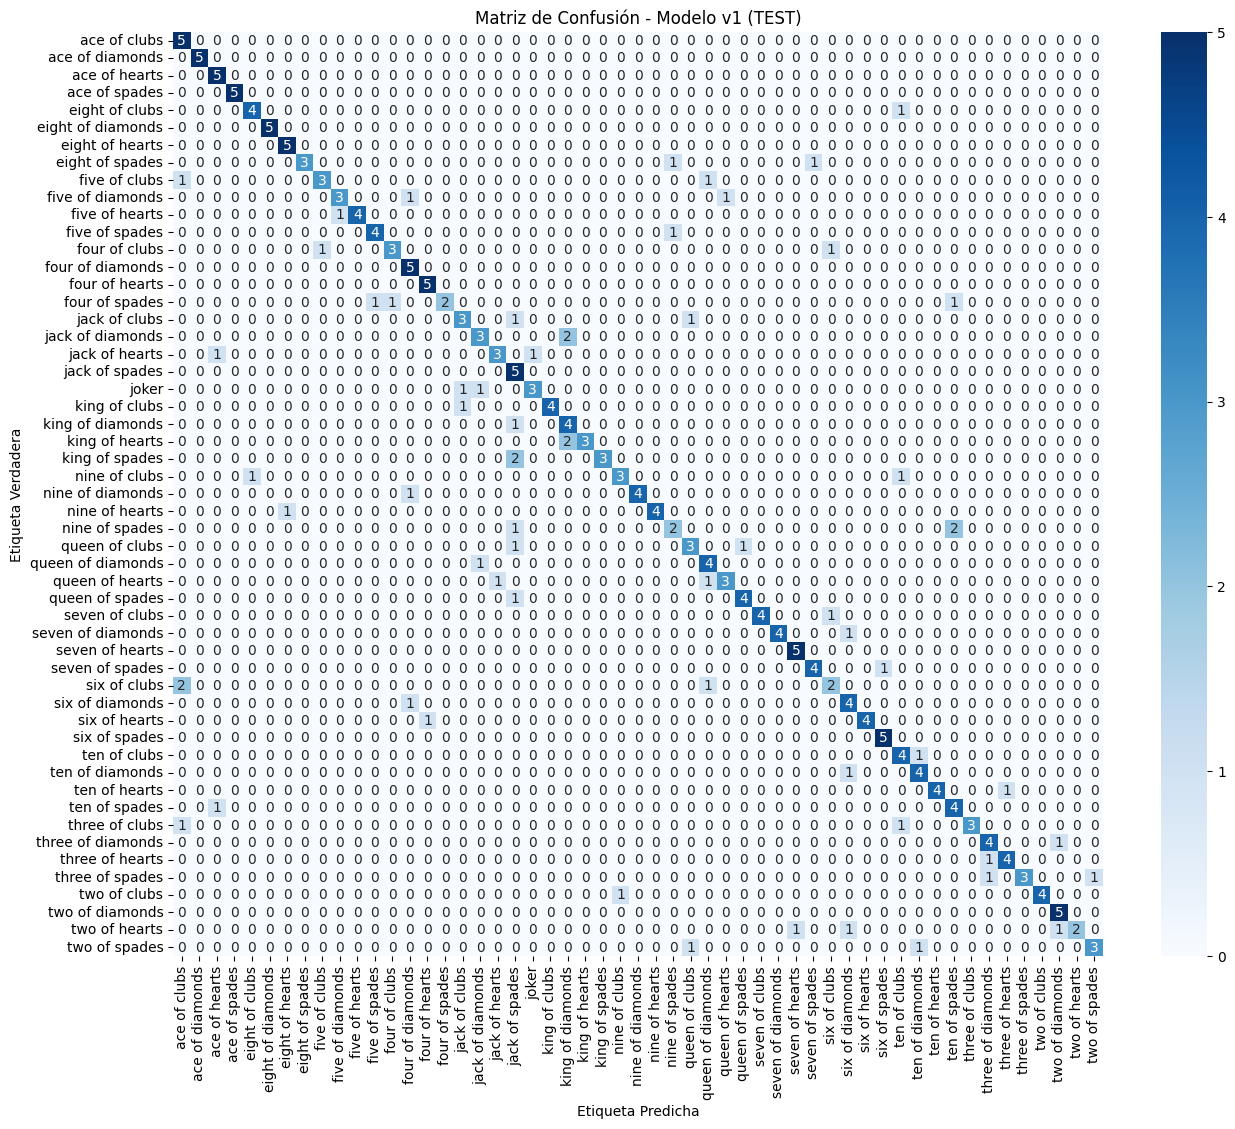

In [7]:
print(">> Evaluación del Modelo v1 con TEST")

# Obtener predicciones
y_pred_prob = model_v1.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Reporte de Clasificación
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(15, 12))
sns.heatmap(cm_df, annot=True, fmt="g", cmap="Blues")
plt.title("Matriz de Confusión - Modelo v1 (TEST)")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.show()

## **5. Modelo v2 (Mejora: Transfer Learning)**

## **6. Comparación de métricas**

## **7. Guardar modelo mejorado**

In [9]:
best_model = model_v1
best_model.save(PROJECT_PATH + "classifier_model.h5")
print(f"Modelo guardado exitosamente en {PROJECT_PATH}")

Modelo guardado exitosamente en /content/drive/MyDrive/Colab Notebooks/AI/DeepLearning/
